# Preprocessing

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import torch

In [4]:
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
import pandas as pd
from src.vfm.model.reg.gradient_boost import GradientBoost
from src.vfm.model.nn.swt_tft import SWTTFTModel
from src.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel, PhysicsModel
from src.utils import *
import matplotlib.pyplot as plt
import os

c:\Users\perer\Documents\Code\pcperera\vfm\.venv\Lib\site-packages\pytorch_forecasting\models\base\_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [5]:
connection = Connection()
# Get client
client = connection.get_client()

In [58]:
df_all_wells = connection.get_data(client, wells=get_all_wells())

In [59]:
df_all_wells.columns


Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm',
       'well_id'],
      dtype='object')

In [60]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [61]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_timeseries(df=df_all_wells)
len(df_all_wells_preprocessed)

Preprocessing well W06... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W08... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W10... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W11... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W15... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W18... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_

729

In [62]:
summarize_null(df_all_wells_preprocessed)

dhp          0
dht          0
whp          0
wht          0
dcp          0
choke        0
well_id      0
qo_mpfm      0
qg_mpfm      0
qw_mpfm      0
time_idx     0
well_code    0
dtype: int64

In [63]:
df_with_targets = df_all_wells_preprocessed.dropna(subset=dependent_vars)
df_with_targets.shape

(729, 12)

In [64]:
summarize_null(df_with_targets)

dhp          0
dht          0
whp          0
wht          0
dcp          0
choke        0
well_id      0
qo_mpfm      0
qg_mpfm      0
qw_mpfm      0
time_idx     0
well_code    0
dtype: int64

In [65]:
df_train, df_test = get_random_train_test_split_per_well_with_order_preserved(df_with_targets)
len(df_train), len(df_test)

(584, 145)

In [67]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
model.fit(df=df_train)

In [68]:
model.physics_score(df_test)

{'W06': {'qo': {'r2': 0.8339908072416723,
   'mae': 12.283287069316188,
   'rmse': 16.047843485112068,
   'mre': 12.927402318251433},
  'qw': {'r2': -0.5275594191805131,
   'mae': 32.85042899469079,
   'rmse': 47.81477614149971,
   'mre': 395396912.6418608},
  'qg': {'r2': 0.811409487090365,
   'mae': 1758.8279874768414,
   'rmse': 2220.2802354484757,
   'mre': 12.984235933185273},
  'wgr': {'r2': -5.946804671887396,
   'mae': 0.002983830007372712,
   'rmse': 0.005162523175596111,
   'mre': 173797.9225325466}},
 'W08': {'qo': {'r2': 0.32993579218833047,
   'mae': 5.430818346721614,
   'rmse': 6.659811399186772,
   'mre': 31.880133828948203},
  'qw': {'r2': -0.051926185963701244,
   'mae': 68.69306655275851,
   'rmse': 94.44178839672718,
   'mre': 201.14405832877048},
  'qg': {'r2': -0.12174269972648633,
   'mae': 714.1467365448306,
   'rmse': 1012.9147006781966,
   'mre': 27.938898113551037},
  'wgr': {'r2': -0.011932486451606827,
   'mae': 0.021650526640338952,
   'rmse': 0.0317488018

In [69]:
model.hybrid_score(df_test)

{'qo': {'r2': 0.5431294351650071,
  'mae': 25.882414248372175,
  'rmse': 32.86763123841746,
  'mre': 48.51445815922427},
 'qw': {'r2': -0.42793505308109947,
  'mae': 92.98705381608461,
  'rmse': 140.28965951703285,
  'mre': 5687363.05775469},
 'qg': {'r2': 0.8714764108056606,
  'mae': 1359.2834824270542,
  'rmse': 2117.547876093576,
  'mre': 13.90701732571131},
 'wgr': {'r2': -0.1861077683653114,
  'mae': 0.009445121183743332,
  'rmse': 0.016612332058424988,
  'mre': 1103.3518803909628}}

In [70]:
df_test.columns

Index(['dhp', 'dht', 'whp', 'wht', 'dcp', 'choke', 'well_id', 'qo_mpfm',
       'qg_mpfm', 'qw_mpfm', 'time_idx', 'well_code'],
      dtype='object')

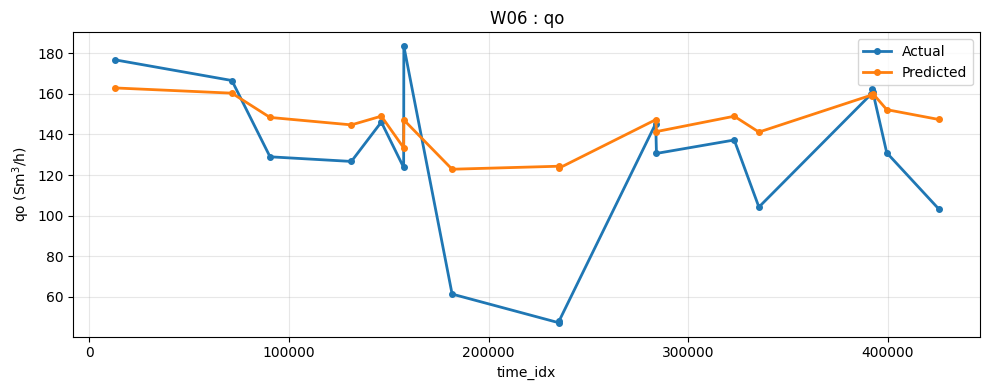

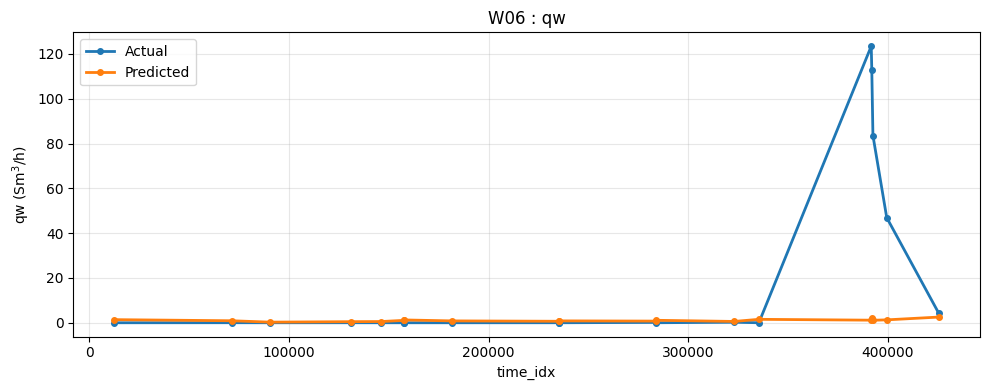

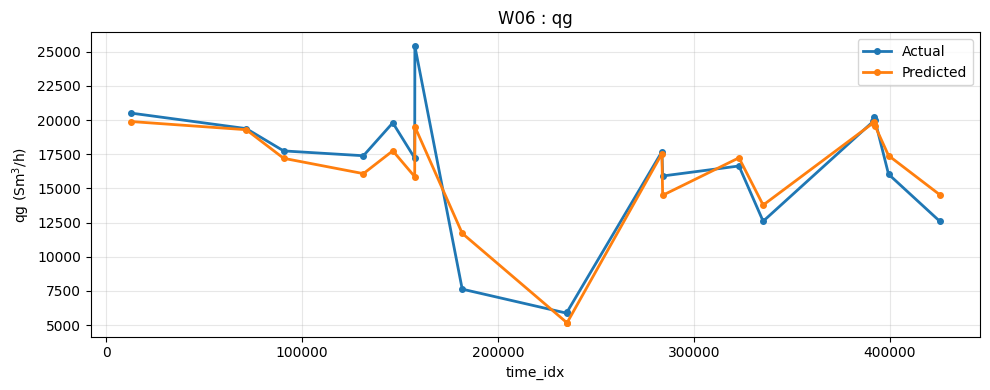

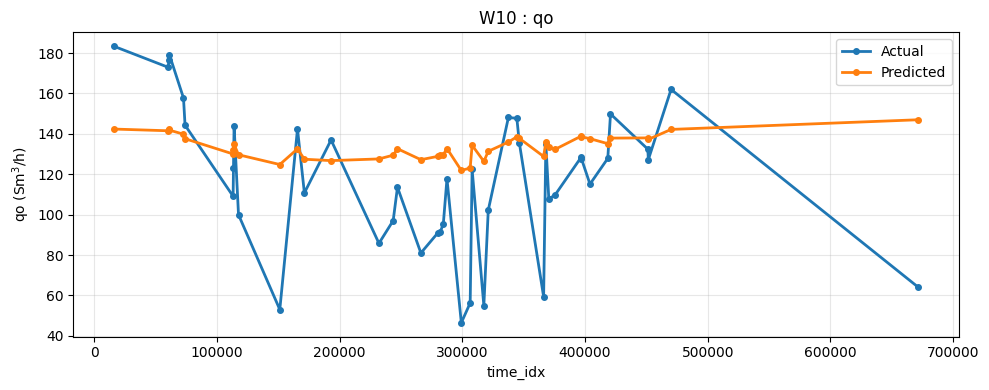

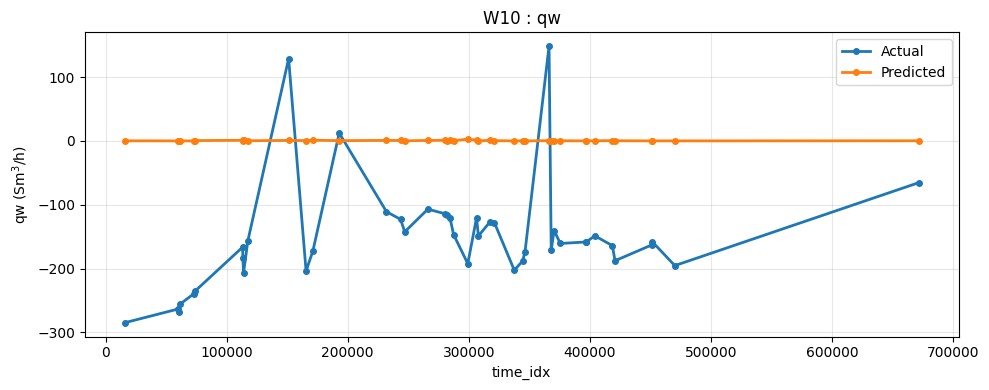

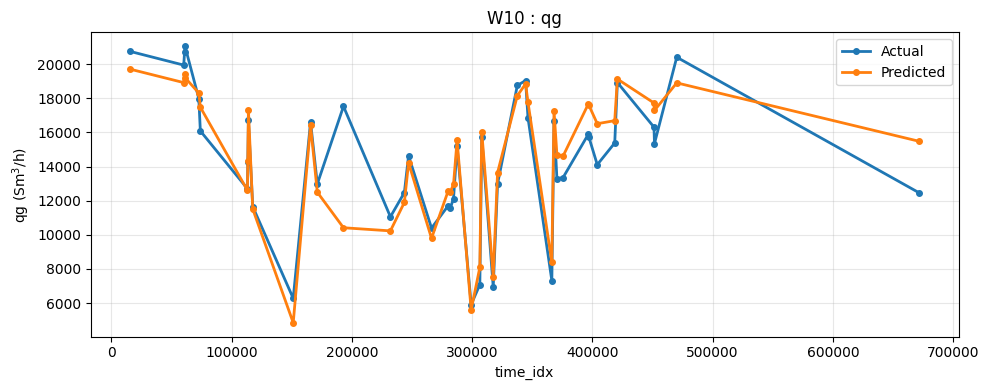

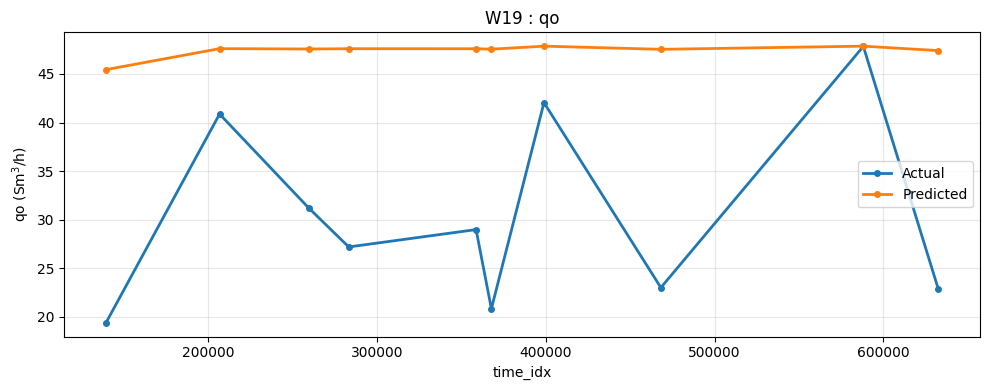

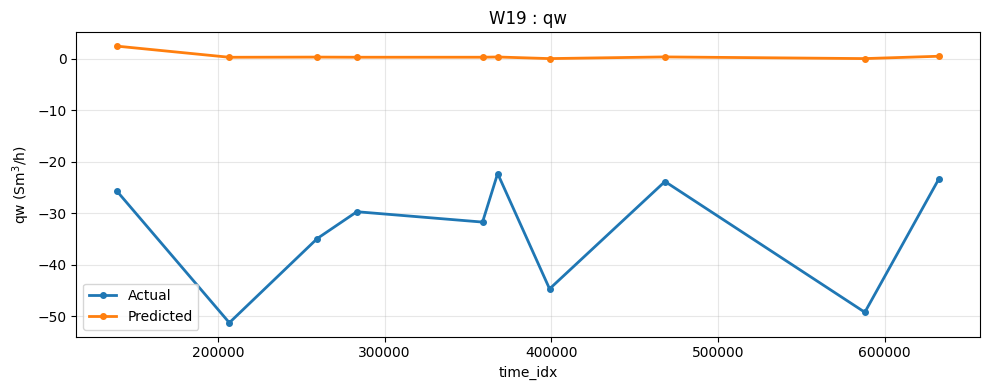

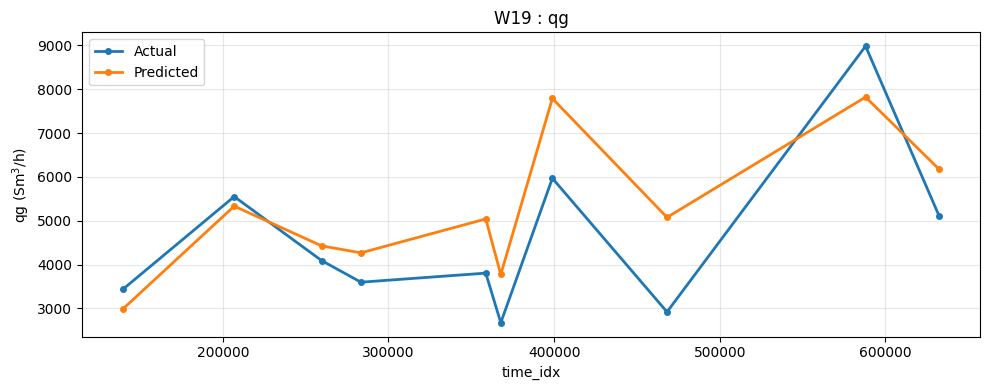

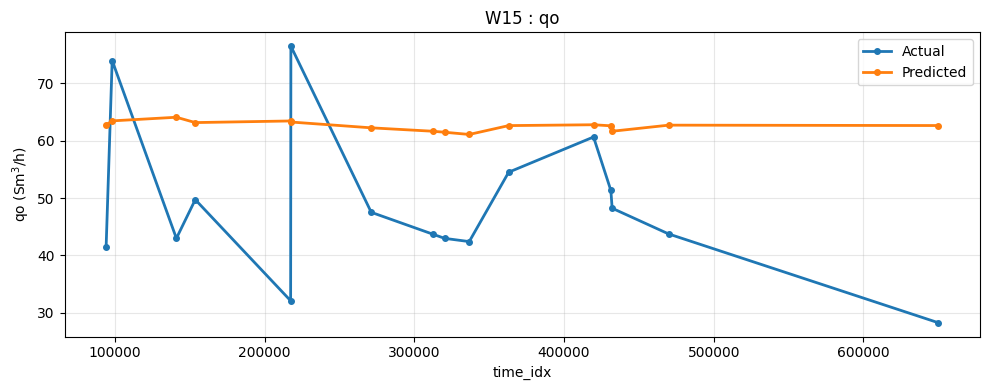

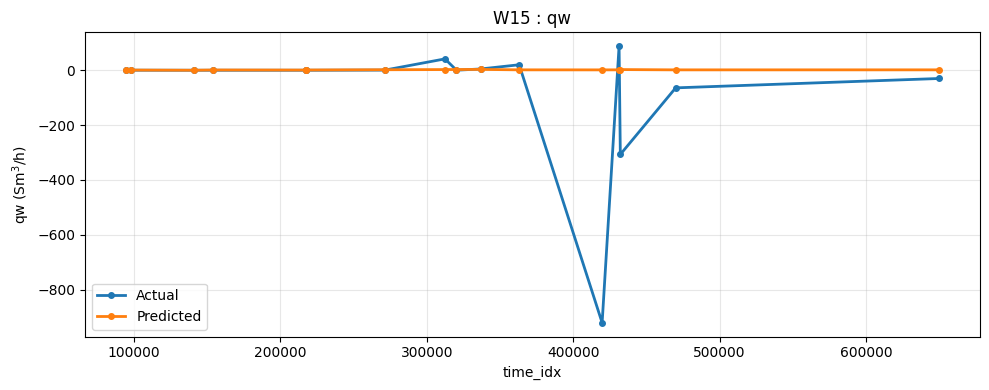

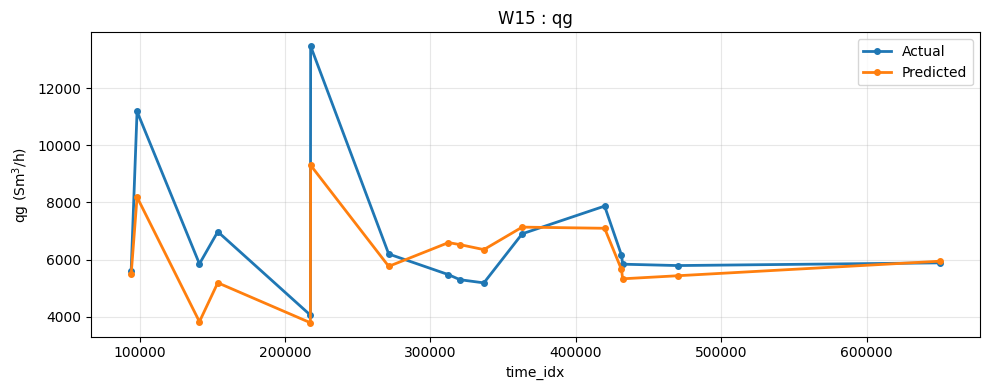

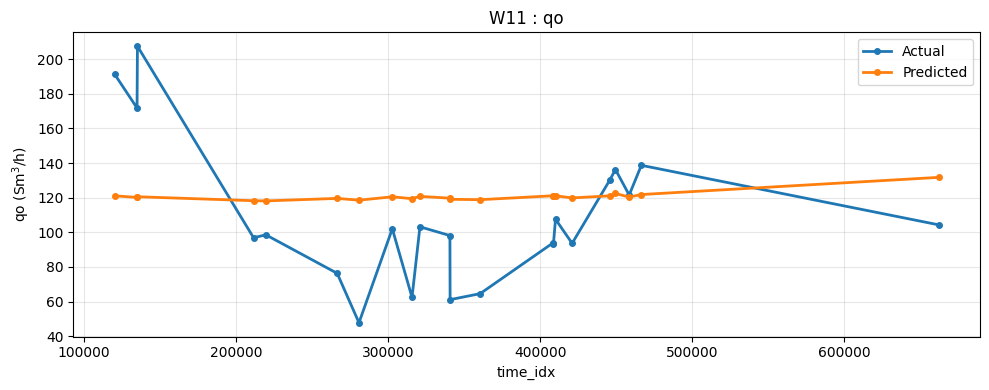

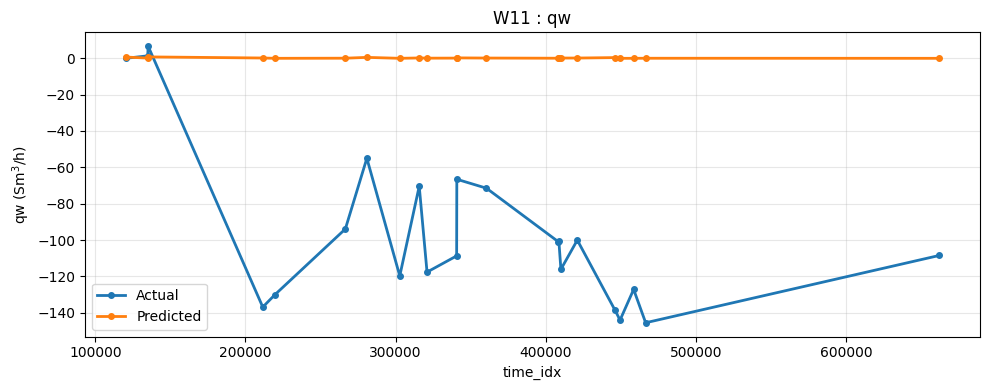

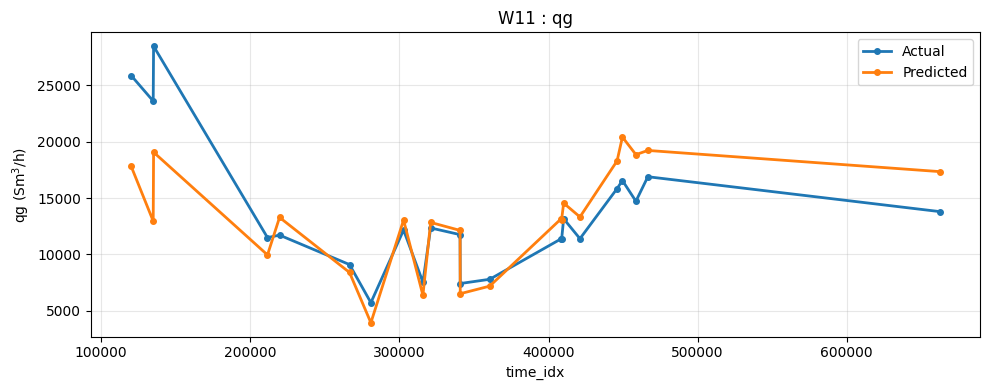

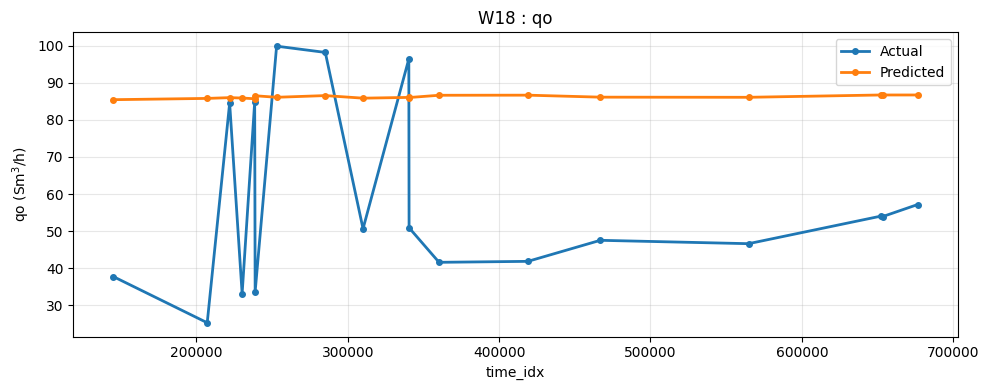

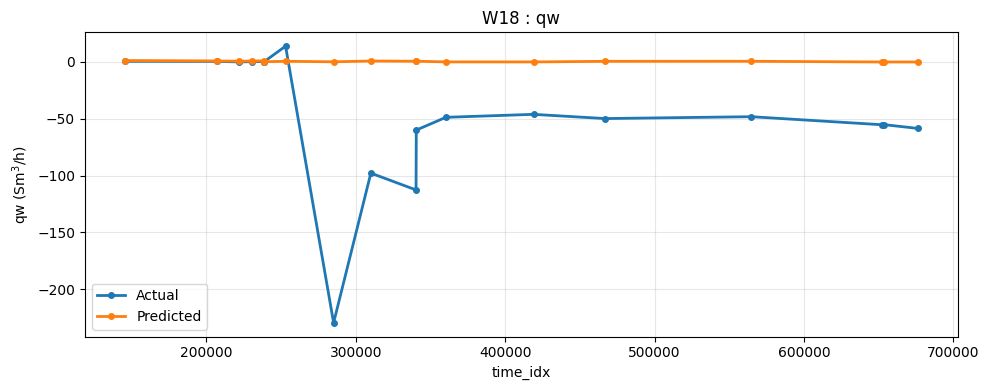

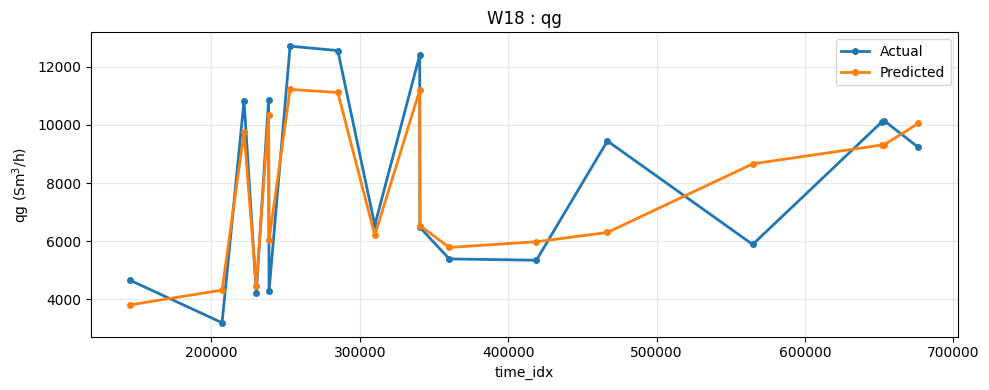

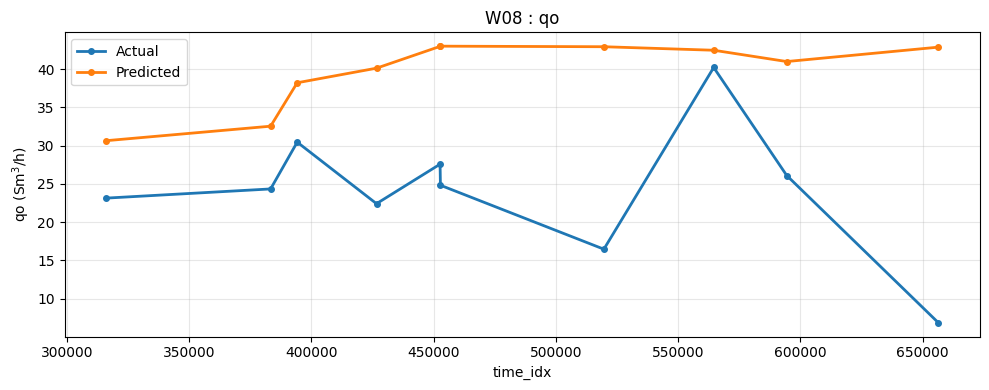

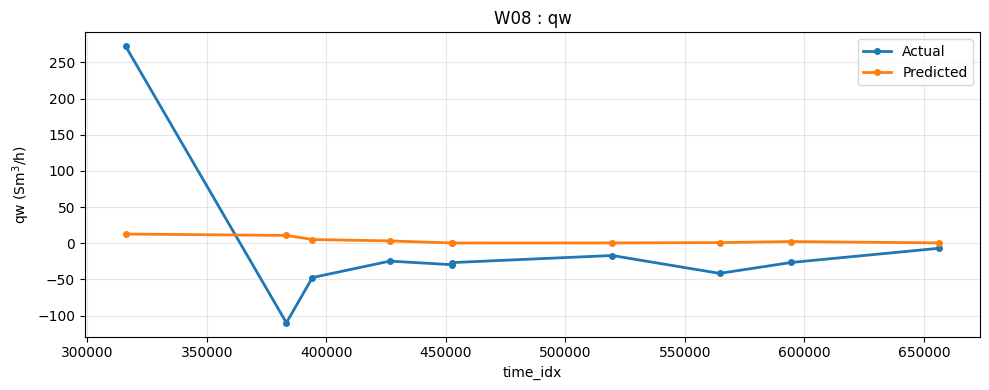

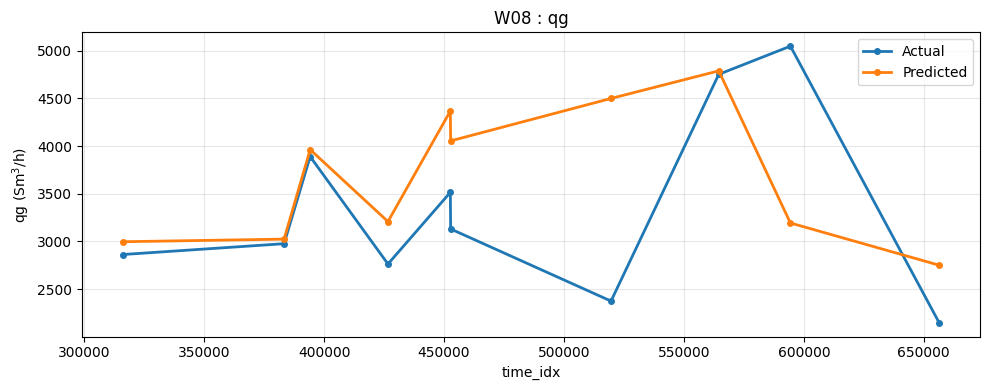

In [71]:
model.plot_predictions(df=df_test, time_col="time_idx", is_hybrid_model=True)

In [72]:
def lowo_with_partial_calibration(
    df,
    n_calibration_points=2,
):
    results = []

    for test_well in df["well_id"].unique():
        df_well = df[df["well_id"] == test_well]
        df_train_other = df[df["well_id"] != test_well]

        df_cal = df_well.iloc[:n_calibration_points]
        df_test = df_well.iloc[n_calibration_points:]

        df_train = pd.concat([df_train_other, df_cal])

        model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
        # model.phys_model.fit_pres = False
        model.fit(df_train)

        results.append({
            "well": test_well,
            "scores": model.hybrid_score(df_test)
        })

    return results


In [73]:
# lowo_with_partial_calibration(df=df_with_targets)